In [1]:
!python -V

Python 3.9.21


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-prediction-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1746540502605, experiment_id='1', last_update_time=1746540502605, lifecycle_stage='active', name='nyc-taxi-prediction-experiment', tags={}>

In [7]:
#df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df = pd.read_csv("./green_tripdata_2021-01.csv")

df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_21111/1107205849.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./green_tripdata_2021-01.csv")


In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

/tmp/ipykernel_21111/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_21111/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


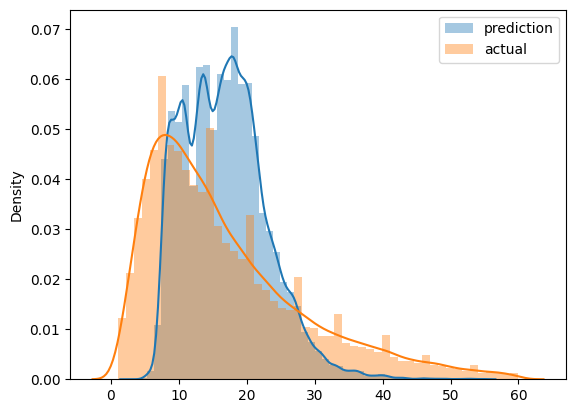

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./green_tripdata_2021-01.csv')
df_val = read_dataframe('./green_tripdata_2021-02.csv')

/tmp/ipykernel_21111/722539646.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [17]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275941179728

In [30]:
import os
assert os.path.exists('./models/lin_reg.bin')

In [32]:
with mlflow.start_run():

    mlflow.set_tag("developer", "ajinkya")
    mlflow.log_param("train-data-path", "./green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./green_tripdata_2021-02.csv")
    mlflow.log_param("model-type", "Lasso")

    alpha =0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path= "./models/lin_reg.bin")

In [33]:
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll import scope

In [34]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [35]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_param("params", params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 200,      # changed to 200 from 1000
            evals = [(valid, "validation")],
            early_stopping_rounds = 50,
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_param("train-data-path", "./green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./green_tripdata_2021-02.csv")
        mlflow.log_param("model-type", "XGBoost")

        for key, value in params.items():
            mlflow.log_param(key, value)

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return rmse
trials = Trials()

In [37]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # [0.05, 1] range for learning rate
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,    
}

best_estimates = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 3,   # changed to 3 from 10
    trials = Trials(),
)


  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [07:59:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68760                         
[1]	validation-rmse:11.20615                         
[2]	validation-rmse:10.76578                         
[3]	validation-rmse:10.36347                         
[4]	validation-rmse:9.99669                          
[5]	validation-rmse:9.66276                          
[6]	validation-rmse:9.35908                          
[7]	validation-rmse:9.08312                          
[8]	validation-rmse:8.83320                          
[9]	validation-rmse:8.60739                          
[10]	validation-rmse:8.40328                         
[11]	validation-rmse:8.21955                         
[12]	validation-rmse:8.05331                         
[13]	validation-rmse:7.90340                         
[14]	validation-rmse:7.76783                         
[15]	validation-rmse:7.64659                         
[16]	validation-rmse:7.53752                         
[17]	validation-rmse:7.44001                         
[18]	validation-rmse:7.35272

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:01:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



 33%|███▎      | 1/3 [03:58<07:56, 238.37s/trial, best loss: 6.480504372030591]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:03:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.01877                                                   
[1]	validation-rmse:8.64901                                                    
[2]	validation-rmse:7.82390                                                    
[3]	validation-rmse:7.33900                                                    
[4]	validation-rmse:7.05676                                                    
[5]	validation-rmse:6.89084                                                    
[6]	validation-rmse:6.78614                                                    
[7]	validation-rmse:6.71685                                                    
[8]	validation-rmse:6.67454                                                    
[9]	validation-rmse:6.64488                                                    
[10]	validation-rmse:6.62479                                                   
[11]	validation-rmse:6.61111                                                   
[12]	validation-rmse:6.60056            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:04:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



 67%|██████▋   | 2/3 [05:18<02:25, 145.01s/trial, best loss: 6.480504372030591]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:05:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.89469                                                    
[1]	validation-rmse:8.50684                                                    
[2]	validation-rmse:7.67846                                                    
[3]	validation-rmse:7.21322                                                    
[4]	validation-rmse:6.94977                                                    
[5]	validation-rmse:6.79719                                                    
[6]	validation-rmse:6.70740                                                    
[7]	validation-rmse:6.63933                                                    
[8]	validation-rmse:6.60507                                                    
[9]	validation-rmse:6.57680                                                    
[10]	validation-rmse:6.55783                                                   
[11]	validation-rmse:6.54548                                                   
[12]	validation-rmse:6.53461            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:06:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



100%|██████████| 3/3 [07:28<00:00, 149.42s/trial, best loss: 6.420047556439891]


In [40]:
mlflow.xgboost.autolog(disable=True)

In [42]:
with mlflow.start_run():
    params2= {
        'learning_rate': 0.20472169880371677,  # [0.05, 1] range for learning rate
        'max_depth': 17,
        'min_child_weight': 1.2402611720043835,
        'objective': 'reg:linear',
        'reg_alpha': 0.28567896734700793,
        'reg_lambda': 0.004264404814393109,
        'seed': 42,
    }

    #mlflow.xgboost.autolog()
    mlflow.log_params(params2)

    booster2 = xgb.train(
        params = params2,
        dtrain = train,
        num_boost_round = 500,    # changed to 500 from 1000
        evals = [(valid, "validation")],
        early_stopping_rounds = 50,
    )

    y_pred = booster2.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster2, artifact_path="models_mlflow")


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:13:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62105
[1]	validation-rmse:9.45454
[2]	validation-rmse:8.61244
[3]	validation-rmse:8.02161
[4]	validation-rmse:7.60613
[5]	validation-rmse:7.31430
[6]	validation-rmse:7.11506
[7]	validation-rmse:6.97578
[8]	validation-rmse:6.87711
[9]	validation-rmse:6.80659
[10]	validation-rmse:6.75482
[11]	validation-rmse:6.71870
[12]	validation-rmse:6.68975
[13]	validation-rmse:6.67024
[14]	validation-rmse:6.65272
[15]	validation-rmse:6.63910
[16]	validation-rmse:6.62823
[17]	validation-rmse:6.62004
[18]	validation-rmse:6.61336
[19]	validation-rmse:6.60866
[20]	validation-rmse:6.60602
[21]	validation-rmse:6.60323
[22]	validation-rmse:6.60192
[23]	validation-rmse:6.60053
[24]	validation-rmse:6.59835
[25]	validation-rmse:6.59609
[26]	validation-rmse:6.59387
[27]	validation-rmse:6.59214
[28]	validation-rmse:6.59088
[29]	validation-rmse:6.58932
[30]	validation-rmse:6.58731
[31]	validation-rmse:6.58478
[32]	validation-rmse:6.58333
[33]	validation-rmse:6.58150
[34]	validation-rmse:6.

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:14:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/12 08:14:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [43]:
logged_model = 'runs:/07e354c0902d4f51b78cdb2b6f15672d/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


In [44]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 07e354c0902d4f51b78cdb2b6f15672d

In [45]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [46]:
xgboost_model

In [48]:
this_model = xgboost_model.predict(valid)

In [50]:
this_model[:10]

array([15.371275,  7.191761, 16.51383 , 24.356516,  9.206848, 17.119337,
       12.649838,  9.013519,  8.975065, 17.98893 ], dtype=float32)